<a href="https://colab.research.google.com/github/fcoliveira-utfpr/climate_parana/blob/main/analises_clima_parana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Início - Bibliotecas
---

In [16]:
# -------------------------
# IMPORTS
# -------------------------
!pip install geobr   -q
import numpy as np
import pandas as pd
import geopandas as gpd
import pandas as pd
from geobr import read_municipality
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import math
import matplotlib.colors as colors
import matplotlib.cm as cm
from geobr import read_municipality
from matplotlib.ticker import FuncFormatter

# Abrindo dados
---

In [50]:
url = "https://raw.githubusercontent.com/fcoliveira-utfpr/climate_parana/refs/heads/main/dados_concatenados_zc.csv"
df = pd.read_csv(url, sep = ",")
df

,estado,lat,lon,municipio,valor,variavel,ZC
0,Parana,-23.311363,-50.306176,ABATIA,210.718086,def,7601
1,Parana,-25.884047,-53.640829,BELA VISTA DA CAROBA,87.526841,def,6801
2,Parana,-24.781986,-48.819381,ADRIANOPOLIS,54.045608,def,6801
3,Parana,-26.025501,-49.309155,AGUDOS DO SUL,33.173108,def,6801
4,Parana,-25.284879,-49.322794,ALMIRANTE TAMANDARE,35.327444,def,6801
...,...,...,...,...,...,...,...
2395,Parana,-23.538200,-53.825424,ALTO PARAISO,28.208377,tmmx,7701
2396,Parana,-25.408510,-52.236439,VIRMOND,24.368879,tmmx,6801
2397,Parana,-26.277366,-52.804057,VITORINO,24.684439,tmmx,6901
2398,Parana,-23.853953,-49.783944,WENCESLAU BRAZ,25.967448,tmmx,7601


#Plotando mapa variáveis
---

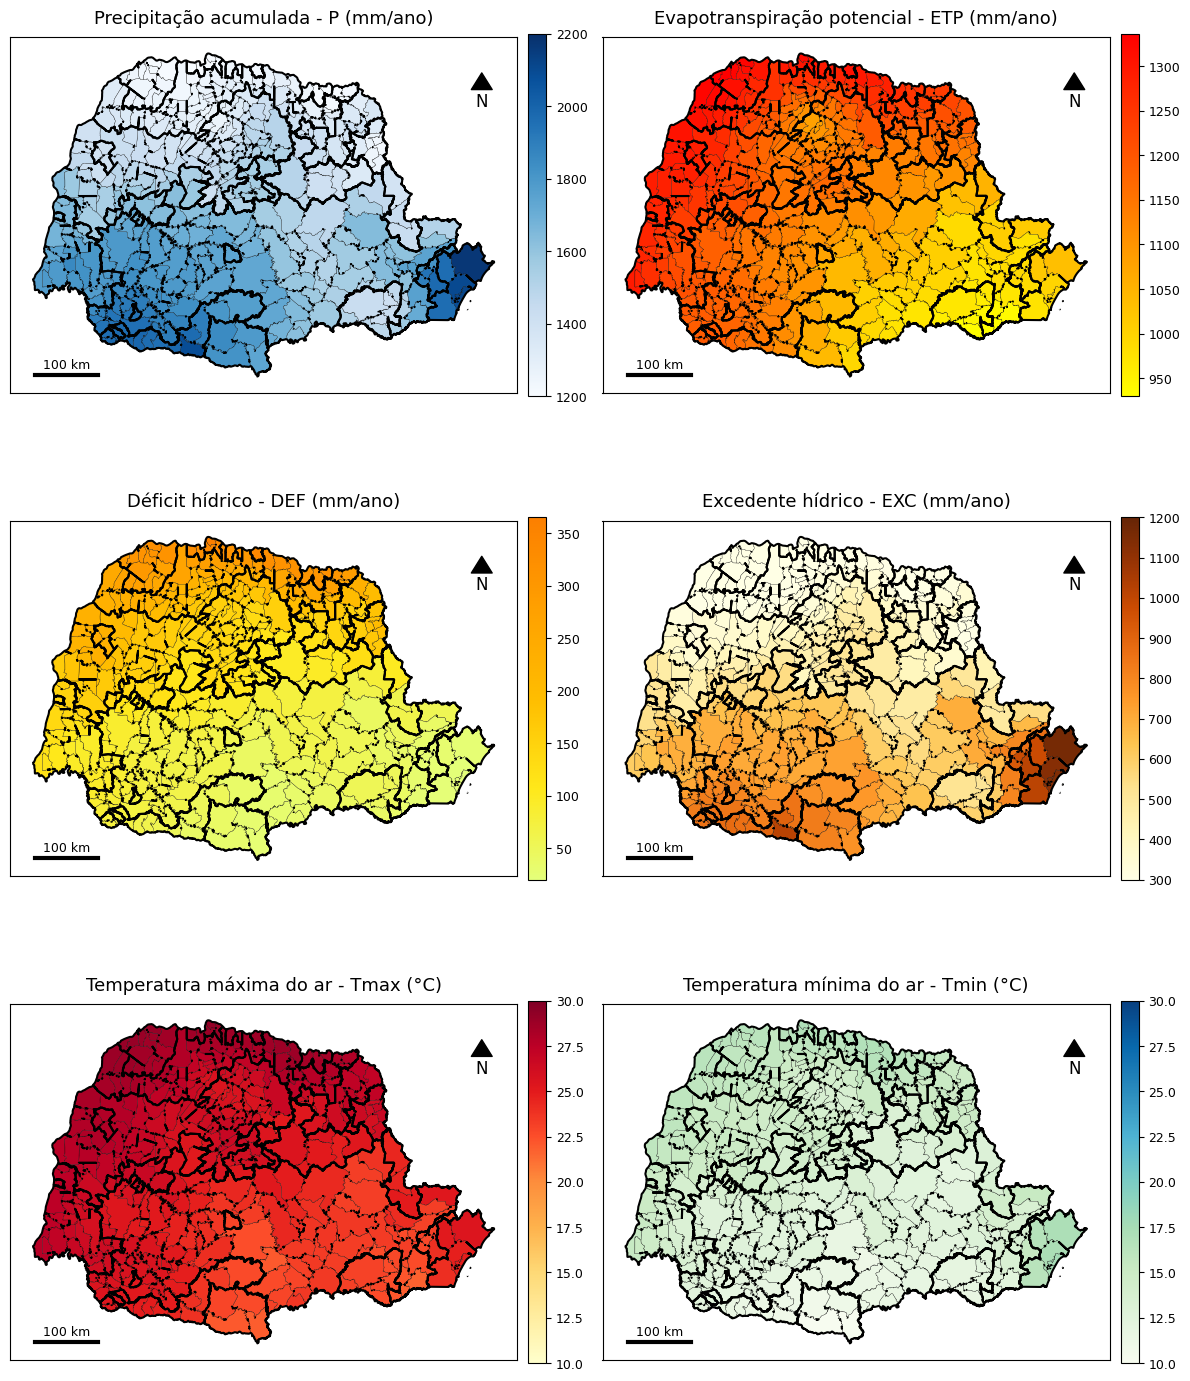

In [53]:
# =========================================================
# MULTIPLOT CLIMÁTICO – PARANÁ
# =========================================================

# -------------------------
# FUNÇÕES AUXILIARES
# -------------------------
def fmt_factory(fmt):
    return FuncFormatter(lambda x, pos: fmt % x)

def add_north_arrow(ax, x=0.93, y=0.9, size=0.08):
    ax.annotate(
        'N',
        xy=(x, y),
        xytext=(x, y - size),
        arrowprops=dict(facecolor='black', width=5, headwidth=15),
        ha='center',
        va='center',
        fontsize=12,
        xycoords=ax.transAxes
    )

def add_scalebar(ax, length_km=100, loc=(0.05, 0.05), linewidth=3):
    """
    Scale bar simples (visual), sem bibliotecas externas
    """
    x0, y0 = loc
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Conversão aproximada: 1 grau ~ 111 km
    length_deg = length_km / 111.0

    x_start = xlim[0] + x0 * (xlim[1] - xlim[0])
    y_start = ylim[0] + y0 * (ylim[1] - ylim[0])

    ax.plot(
        [x_start, x_start + length_deg],
        [y_start, y_start],
        color='black',
        linewidth=linewidth
    )

    ax.text(
        x_start + length_deg / 2,
        y_start + 0.01 * (ylim[1] - ylim[0]),
        f"{length_km} km",
        ha='center',
        va='bottom',
        fontsize=9
    )

# -------------------------
# SPECS DAS VARIÁVEIS
# -------------------------
VAR_SPECS = {
    'pr':   dict(title="Precipitação acumulada - P",       unit="mm/ano", cmap='Blues',    vmin=1200, vmax=2200, fmt="%.0f"),
    'pet':  dict(title="Evapotranspiração potencial - ETP", unit="mm/ano", cmap='autumn_r', vmin=930,  vmax=1336, fmt="%.0f"),
    'def':  dict(title="Déficit hídrico - DEF",             unit="mm/ano", cmap='Wistia',   vmin=20,   vmax=365,  fmt="%.0f"),
    'ro':   dict(title="Excedente hídrico - EXC",           unit="mm/ano", cmap='YlOrBr',   vmin=300,  vmax=1200, fmt="%.0f"),
    'tmmx': dict(title="Temperatura máxima do ar - Tmax",   unit="°C",     cmap='YlOrRd',   vmin=10,   vmax=30,   fmt="%.1f"),
    'tmmn': dict(title="Temperatura mínima do ar - Tmin",   unit="°C",     cmap='GnBu',     vmin=10,   vmax=30,   fmt="%.1f"),
}

vars_plot = list(VAR_SPECS.keys())

# -------------------------
# MUNICÍPIOS DO PARANÁ
# -------------------------
mun_pr = read_municipality(code_muni="PR", year=2020)

mun_pr['municipio'] = (
    mun_pr['name_muni']
    .str.upper()
    .str.normalize('NFKD')
    .str.encode('ascii', errors='ignore')
    .str.decode('utf-8')
)

# -------------------------
# LAYOUT DA FIGURA
# -------------------------
n_vars = len(vars_plot)
ncols = 2
nrows = math.ceil(n_vars / ncols)

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(12, 5 * nrows)
)

axes = axes.flatten()

# -------------------------
# LOOP DE MAPAS
# -------------------------
for i, variavel in enumerate(vars_plot):

    ax = axes[i]
    spec = VAR_SPECS[variavel]

    df_variavel = df[df['variavel'] == variavel].copy()

    df_variavel['municipio'] = (
        df_variavel['municipio']
        .str.upper()
        .str.normalize('NFKD')
        .str.encode('ascii', errors='ignore')
        .str.decode('utf-8')
    )

    gdf_pr = mun_pr.merge(df_variavel, on='municipio', how='left')

    gdf_pr.plot(
        column='valor',
        cmap=spec['cmap'],
        vmin=spec['vmin'],
        vmax=spec['vmax'],
        linewidth=0.2,
        edgecolor='black',
        ax=ax
    )

    norm = colors.Normalize(vmin=spec['vmin'], vmax=spec['vmax'])
    sm = cm.ScalarMappable(norm=norm, cmap=plt.get_cmap(spec['cmap']))
    sm.set_array([])

    cbar = fig.colorbar(
        sm,
        ax=ax,
        fraction=0.046,
        pad=0.02,
        shrink=0.72,
        format=fmt_factory(spec['fmt'])

    )
    cbar.ax.tick_params(labelsize=9)

    add_scalebar(ax, length_km=100)
    add_north_arrow(ax)

    ax.set_title(f"{spec['title']} ({spec['unit']})", fontsize=13, pad=10)
    ax.set_xticks([])
    ax.set_yticks([])

    # Dissolver municípios por zona
    zones = gdf_pr.dissolve(by='ZC')

    # Plotar bordas das zonas por cima
    zones.boundary.plot(
        ax=ax,
        linewidth=1.5,
        edgecolor='black'
    )

# -------------------------
# REMOVER EIXOS VAZIOS
# -------------------------
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()
